# Deconvolution Analysis (DANA)

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import time

In [3]:
from dataclasses import dataclass

In [4]:
import invisible_cities.core.system_of_units  as units
from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.io.dst_io    import load_dst
from invisible_cities.core.core_functions import in_range

In [5]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [6]:
from nextflex.core import Setup
from nextflex.core import KEY_sensor_fibres 
from nextflex.core import KEY_sensor_pmts   
from nextflex.core import S1_time           
from nextflex.core import SIPM_ids
from nextflex.core import get_sipm_postions
from nextflex.core import get_sensor_response

In [7]:
from nextflex.graphics_reco   import plot_hits3d

In [8]:
from  tics.stats_tics import bin_data_with_equal_bin_size
from tics.pd_tics   import get_index_slice_from_multi_index
from tics.util_tics   import find_nearest

In [9]:
from nextflex.types import EventHits

In [10]:
from nextflex.types import  ResponseSiPM
from nextflex.reco_functions import get_sipm_response
from nextflex.reco_functions import get_sipm_positions
from nextflex.reco_functions import get_event_sipm
from nextflex.reco_functions import get_sipm_event_hits

In [320]:
from nextflex.graphics_reco   import plot_hits3d
from nextflex.graphics_reco   import plot_hits_projections
from nextflex.graphics_reco   import plot_hits_xy
from nextflex.graphics_reco   import bin_hits
from nextflex.graphics_reco   import bin_hits_xy


In [12]:
from nextflex.tracks_dst import event_reco_hits

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [15]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from skimage.measure import label, regionprops
from skimage import data, util
from skimage.measure import label
from skimage.measure._regionprops import RegionProperties

In [322]:
from nextflex.reco_image_functions import label_slice
from nextflex.reco_image_functions import select_slice_by_label
from nextflex.reco_image_functions import image_from_df
from nextflex.reco_image_functions import detector_grid
from nextflex.reco_image_functions import Point
from nextflex.reco_image_functions import get_psf
from nextflex.reco_image_functions import lr_deconvolution
from nextflex.reco_image_functions import Point

In [17]:
from invisible_cities. reco.deconv_functions import deconvolution_input
from invisible_cities. reco.deconv_functions import richardson_lucy
from invisible_cities. reco.deconv_functions import deconvolve
from invisible_cities.cities.beersheba         import DeconvolutionMode
from invisible_cities.  reco.deconv_functions  import InterpolationMethod
from invisible_cities.cities.beersheba         import CutType
from invisible_cities.core.core_functions import shift_to_bin_centers

## Code

In [18]:
def rebin_time(df : pd.DataFrame)->pd.Series:
        """
        takes the mean time and the energy sum

        """
        d = {}
        d['time'] = df['time'][0]
        d['charge'] = df['charge'].sum()
        return pd.Series(d)


## Setup

In [19]:
FDATA = os.environ['FLEXDATA']
testDir  = os.path.join(FDATA,"testSetupData")
print(f"test dir = {testDir}")

test dir = /Users/jj/Development/flexdata/testSetupData


In [20]:
setbb = Setup(flexDATA = testDir,
              tpConfig = "FLEX100_M6_O6.EL8bar.bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu
        analysis directory           = /Users/jj/Development/flexdata/testSetupData/analysis/FLEX100_M6_O6.EL8bar.bb0nu
        number of h5 files in dir    = 1
        sipm map at                  = /Users/jj/Development/flexdata/testSetupData/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/testSetupData/kdsts/FLEX100_M6_O

In [21]:
setbb.ifnames[0]

'/Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5'

In [22]:
setbb.pitch

15.55

In [23]:
setbb.mc_config()

,param_value
param_key,
num_events,4
TP_SiPM_binning,1.000000 mus
/Geometry/NextFlex/e_lifetime,1000. ms
/Geometry/NextFlex/el_gap_length,10. mm
/Geometry/NextFlex/el_field_int,16. kilovolt/cm
/Geometry/NextFlex/tp_teflon_thickness,6. mm
/Geometry/NextFlex/tp_teflon_hole_diam,6. mm
/Geometry/NextFlex/tp_sipm_sizeX,1.3 mm
/Geometry/NextFlex/tp_sipm_pitchX,15.55 mm


In [25]:
ifname = setbb.ifnames[0]

#### get_sipm_response

In [26]:
start_time = time.perf_counter() 
sipm_response = get_sipm_response(ifname)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")

run time = 0.2970648659999995


In [28]:
start_time = time.perf_counter() 
sipm_evts = get_index_slice_from_multi_index(sipm_response.df, i = 0)
sipm_ids = get_index_slice_from_multi_index(sipm_response.df, i = 1)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")

run time = 0.1646932779999588


#### get_sipm_positions

In [30]:
sipm_positions = get_sipm_positions(ifname)
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[0])

## Deconvolution

### Deconvolve the longest slice in event (5 pes cut)

#### get_sipm_event_hits (cut at 5 pes)

In [34]:
start_time = time.perf_counter() 
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut = 5)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")                 

run time = 0.1440954070000089


In [35]:
sipm_hits.df

,x,y,z,energy
0,-62.200001,-482.049988,785.0,7
1,-62.200001,-482.049988,786.0,6
2,-62.200001,-482.049988,787.0,13
3,-62.200001,-482.049988,788.0,9
4,-62.200001,-482.049988,789.0,8
...,...,...,...,...
1214,-93.300003,-139.949997,903.0,6
1215,-93.300003,-139.949997,904.0,6
1216,-93.300003,-139.949997,905.0,8
1217,-435.399994,-124.400002,788.0,6


#### Plot hits

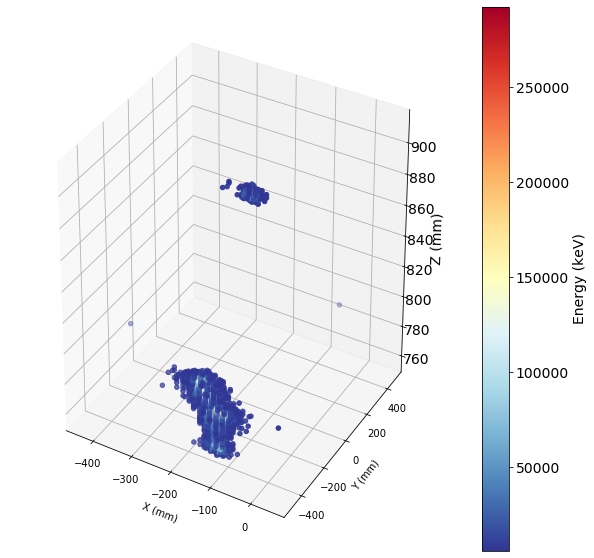

In [36]:
plot_hits3d(sipm_hits,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [37]:
binHits = bin_hits(sipm_hits)

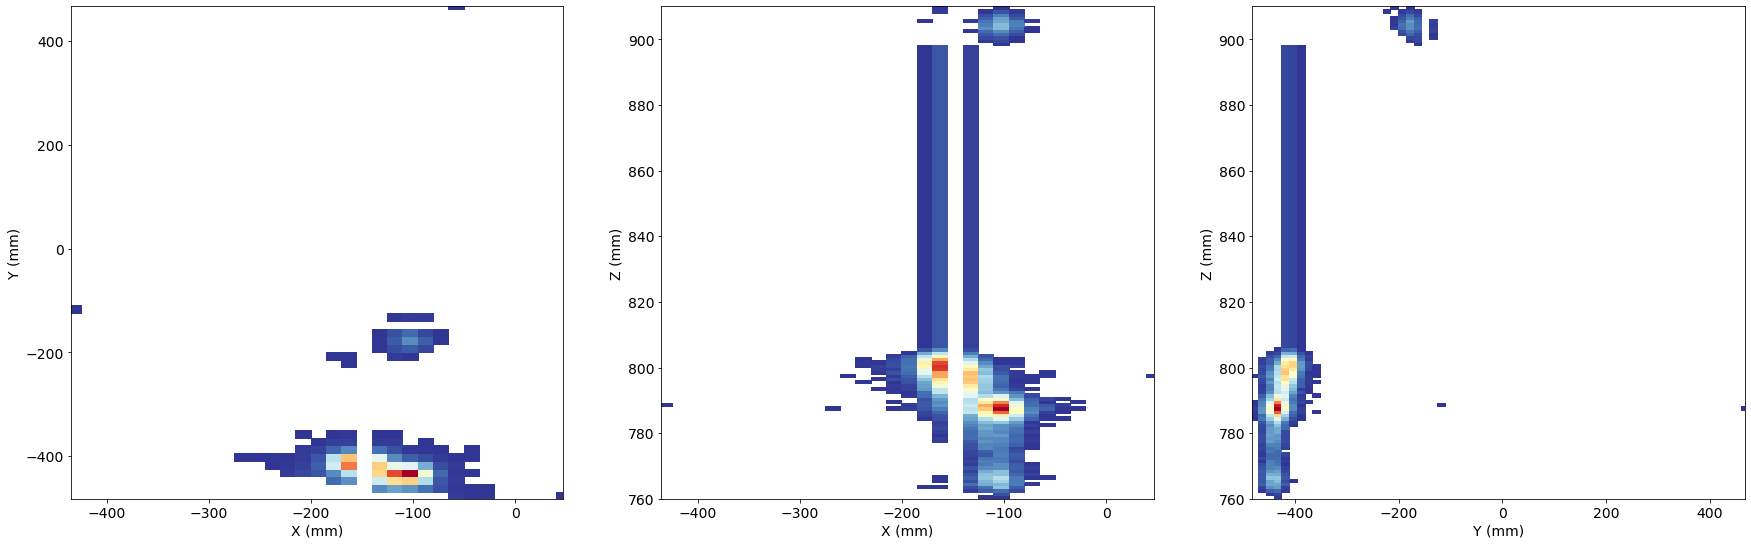

In [38]:
plot_hits_projections(sipm_hits, binHits,  masked=True, figsize=(30, 10))

### Prepare data

#### Deconvolution parameters

In [62]:
bin_size      = (1., 1.)
sample_width  = (15.5, 15.5)
inter_method    = InterpolationMethod.cubic

#### Total and max energy

In [39]:
etot = sipm_hits.df.energy.sum()
emax = sipm_hits.df.energy.max()
print(f" Total energy = {etot}, max energy = {emax}")

 Total energy = 35351, max energy = 292


#### Slicing in z 

In [40]:
zsl = np.unique(sipm_hits.df.z.values)
print(f"number of z slices = {len(zsl)}")

number of z slices = 60


In [41]:
len_slices = [len(sipm_hits.df[sipm_hits.df.z == zs]) for zs in zsl]

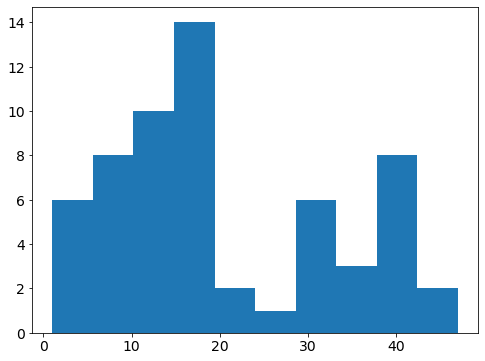

In [42]:
_ = plt.hist(len_slices)

In [43]:
lmax = np.max(len_slices)
ilmax = np.argmax(len_slices)
print(f" length of slice (max) ={lmax}, i = {ilmax}")

 length of slice (max) =47, i = 27


### Deconvolve longer slice

In [44]:
dfzm = sipm_hits.df[sipm_hits.df.z == zsl[ilmax]].reset_index(drop=True)

In [45]:
dfzm.head()

,x,y,z,energy
0,-62.200001,-482.049988,787.0,13
1,-31.100000,-482.049988,787.0,6
2,-139.949997,-466.500000,787.0,30
3,-124.400002,-466.500000,787.0,30
4,-108.849998,-466.500000,787.0,28


In [55]:
print(f"""
Larger slice in z at position = {zsl[ilmax]}
numper of hits                = {len(dfzm)}
max energy =                  = {dfzm.energy.max()}
        """)


Larger slice in z at position = 787.0
numper of hits                = 47
max energy =                  = 292
        


In [56]:
dfzn = dfzm.copy()

In [57]:
dfzn['energy'] = dfzn.energy / emax

In [58]:
dfzn.energy.max()

1.0

In [59]:
dfzn.head()

,x,y,z,energy
0,-62.200001,-482.049988,787.0,0.044521
1,-31.100000,-482.049988,787.0,0.020548
2,-139.949997,-466.500000,787.0,0.102740
3,-124.400002,-466.500000,787.0,0.102740
4,-108.849998,-466.500000,787.0,0.095890


In [60]:
binHits = bin_hits_xy(dfzn)

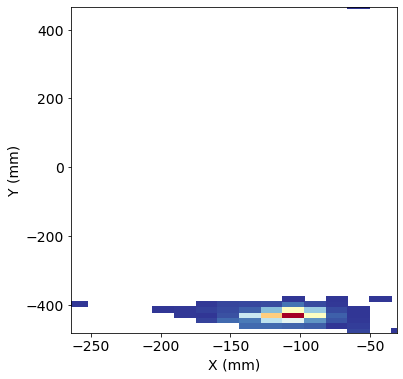

In [61]:
plot_hits_xy(dfzn, binHits,  masked=True, figsize=(6, 6))

##### Notice isolated clusters (cut at 5 pes is low)

#### Labelling a slice in z and selecting by label

In [199]:
sckl = label_slice(dfzn)

##### Label matrix shows 5 regions, only one has a cluster of SiPMs all the others are isolated SiPMs

In [87]:
sckl.lbl

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        

##### Properties has 5 regions (corresponding to labeling)

In [92]:
len(sckl.prp)

5

In [201]:
print_properties(sckl.prp)

 region = 0,
        size        = 1
        label       = 1
        diameter    = 1.1283791670955126
        euler number= 1
        extent      = 1.0
        filled area = 1
        coordinates = [[0 5]]
        intensity   = [[6.]]
        
 region = 1,
        size        = 10
        label       = 2
        diameter    = 7.399277020331919
        euler number= 1
        extent      = 0.6142857142857143
        filled area = 43
        coordinates = [[ 4  4]
 [ 5  3]
 [ 5  4]
 [ 6  2]
 [ 6  3]
 [ 6  4]
 [ 6  5]
 [ 7  2]
 [ 7  3]
 [ 7  4]
 [ 7  5]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [ 8  5]
 [ 9  1]
 [ 9  2]
 [ 9  3]
 [ 9  4]
 [ 9  5]
 [10  1]
 [10  2]
 [10  3]
 [10  4]
 [10  5]
 [10  6]
 [11  1]
 [11  2]
 [11  3]
 [11  4]
 [11  5]
 [12  1]
 [12  2]
 [12  3]
 [12  4]
 [12  5]
 [12  6]
 [13  0]
 [13  1]
 [13  2]
 [13  3]
 [13  4]]
        intensity   = [[  0.   0.   0.   0.   6.   0.   0.]
 [  0.   0.   0.   8.   8.   0.   0.]
 [  0.   0.  12.   7.  11.   8.   0.]
 [  0.   0.  30.  

##### In the selection by size we require a size of at least 2 (no isolated SiPMs)

In [202]:
dfzs = select_slice_by_label(dfzn, sckl, min_size=2)

In [203]:
dfzs.head()

,x,y,energy
0,-31.100000,-482.049988,0.020548
1,-62.200001,-450.950012,0.027397
2,-62.200001,-450.950012,0.027397
3,-171.050003,-450.950012,0.041096
4,-77.750000,-466.500000,0.023973


In [209]:
print(f""" 
selection in z:
xmin = {dfzs.x.min()}
xmax = {dfzs.x.max()}
ymin = {dfzs.y.min()}
ymax = {dfzs.y.max()}

""")

 
selection in z:
xmin = -171.0500030517578
xmax = -31.100000381469727
ymin = -482.04998779296875
ymax = -404.29998779296875




In [210]:
xx = dfzs.x.mean()
yy = dfzs.y.mean()
zz = dfzn.z.values[0]
print(f"xmean = {xx}, ymean={yy} zmean = {zz}")

xmean = -102.34069779861805, ymean=-447.33372249159703 zmean = 787.0


#### Prepare detector grid

In [159]:
det_grid = detector_grid(dfzs, bin_size)

In [160]:
izn = image_from_df(dfzs, det_grid, sample_width)

[[-194.3000030517578, -7.850000381469727], [-505.29998779296875, -381.04998779296875]]


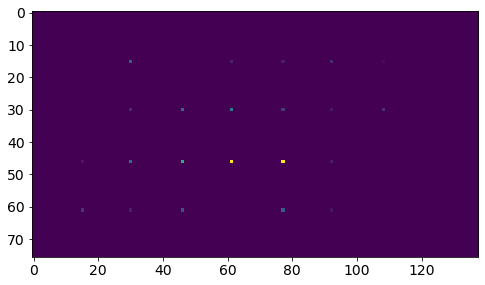

In [162]:
plt.imshow(izn.T)

#### Interpolation 

In [163]:
interpolator = deconvolution_input(sample_width, 
                                   det_grid, 
                                   inter_method)

In [164]:
inter_values, inter_pos = interpolator((dfzs.x.values, dfzs.y.values), dfzs.energy.values)

In [165]:
len(inter_values.flatten())

10703

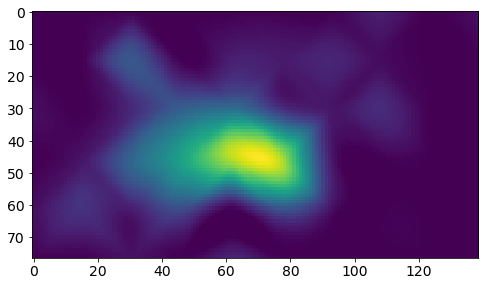

In [166]:
plt.imshow(inter_values.T)

In [167]:
inter_pos[0].shape

(10703,)

In [168]:
dfzi = pd.DataFrame({'x' : inter_pos[0].flatten(), 
                     'y' : inter_pos[1].flatten(), 
                     'energy' : inter_values.flatten() })

In [169]:
dfzi

,x,y,energy
0,-170.550003,-481.549988,0.000000
1,-170.550003,-480.549988,0.000000
2,-170.550003,-479.549988,0.000000
3,-170.550003,-478.549988,0.000000
4,-170.550003,-477.549988,0.000000
...,...,...,...
10698,-32.550003,-409.549988,0.000175
10699,-32.550003,-408.549988,0.000121
10700,-32.550003,-407.549988,0.000064
10701,-32.550003,-406.549988,0.000009


In [170]:
binHits = bin_hits_xy(dfzi,
            xr = (dfzi.x.min(), dfzi.x.max()),
            yr = (dfzi.y.min(), dfzi.y.max()),
            pitch = (1, 1))

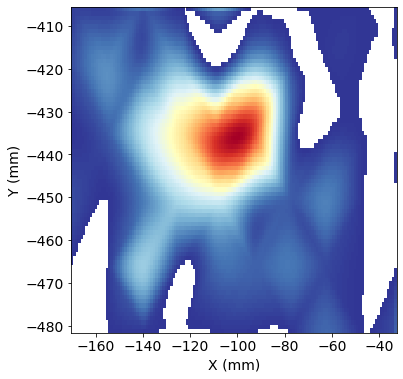

In [171]:
plot_hits_xy(dfzi, binHits,  masked=True, figsize=(6, 6))

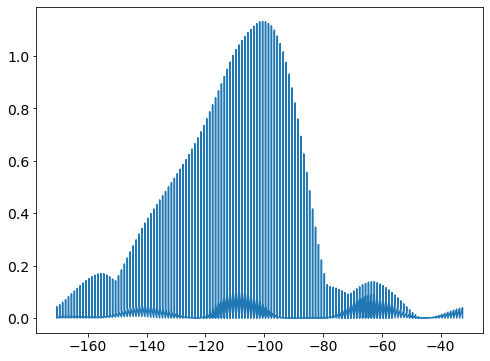

In [172]:
plt.plot(dfzi.x, dfzi.energy)

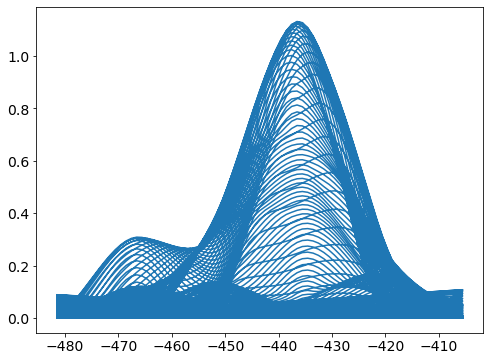

In [173]:
plt.plot(dfzi.y, dfzi.energy)

#### PSF

In [ ]:
pspath = os.path.join(FDATA, "PSFs")
psfname = "PSF_flex_EL_diff.h5"

In [212]:
xyz = Point(xx,yy,zz)

In [214]:
psf_deco = get_psf(pspath, psfname, dfzs, xyz)

In [216]:
psf_deco.shape

(200, 200)

#### RL deconvolution

In [217]:
start_time = time.perf_counter() 
deconv_image  = np.nan_to_num(richardson_lucy(inter_values, psf_deco, 70, 1e-10))
                                                     
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'LR from IC run in {run_time} seconds')

LR from IC run in 0.46064149199992244 seconds


In [220]:
deconv_image

array([[1.03824316e-67, 4.09472841e-66, 1.50488900e-64, ...,
        2.82474457e-23, 9.10893410e-25, 2.22818007e-26],
       [2.00665415e-65, 8.36453216e-64, 3.20929388e-62, ...,
        1.03695632e-21, 3.25807260e-23, 7.75154546e-25],
       [4.11783066e-63, 1.81282534e-61, 7.25358269e-60, ...,
        2.90408949e-20, 8.90972837e-22, 2.06697658e-23],
       ...,
       [3.73210990e-33, 2.03468394e-32, 8.00116009e-32, ...,
        4.80797949e-86, 3.12594554e-87, 1.81290499e-88],
       [4.11732048e-34, 2.17954550e-33, 8.29079212e-33, ...,
        4.46527272e-88, 3.03301281e-89, 1.84803134e-90],
       [3.82505315e-35, 1.97177864e-34, 7.28062770e-34, ...,
        4.03684097e-90, 2.86794189e-91, 1.83827002e-92]])

In [221]:
deconv_image.T.shape

(77, 139)

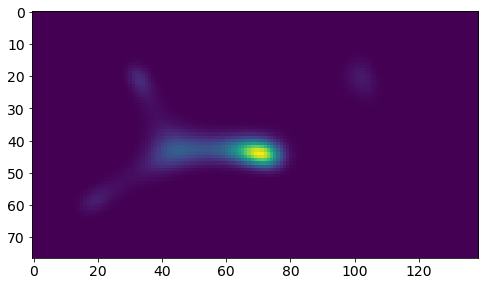

In [222]:
plt.imshow(deconv_image.T)

In [225]:
deconv_image.shape

(139, 77)

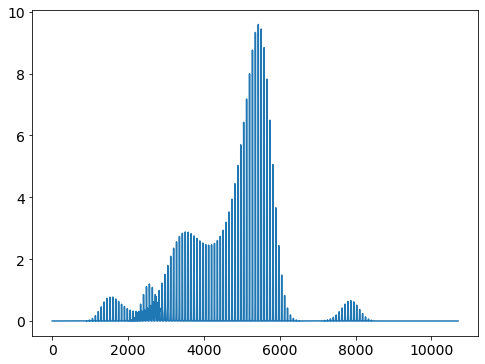

In [226]:
plt.plot(deconv_image.flatten())

In [227]:
dcdf = pd.DataFrame({"x" : inter_pos[0],
                     "y" : inter_pos[1],
                    "energy" : deconv_image.flatten()})

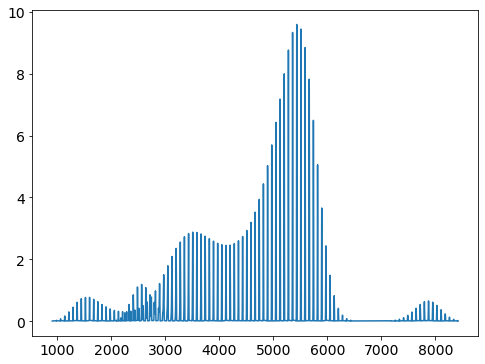

In [228]:
plt.plot(dcdf.energy[dcdf.energy>0.01])

In [229]:
dcdf = dcdf[dcdf.energy>0.01]

In [230]:
binHits = bin_hits_xy(dcdf,
            xr = (dcdf.x.min(), dcdf.x.max()),
            yr = (dcdf.y.min(), dcdf.y.max()),
            pitch = (1, 1))

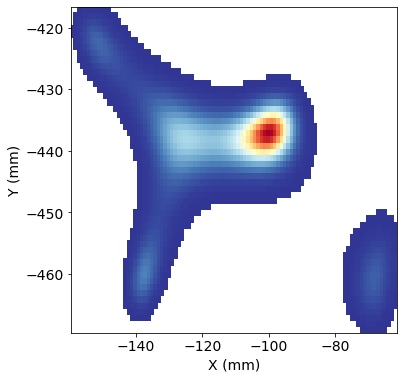

In [231]:
plot_hits_xy(dcdf, binHits,  masked=True, figsize=(6, 6))

### Deconvolve the longest slice in event (10 pes cut)

#### get_sipm_event_hits (cut at 5 pes)

In [236]:
start_time = time.perf_counter() 
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut = 10)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")                 

run time = 0.08359029500024917


#### Plot hits

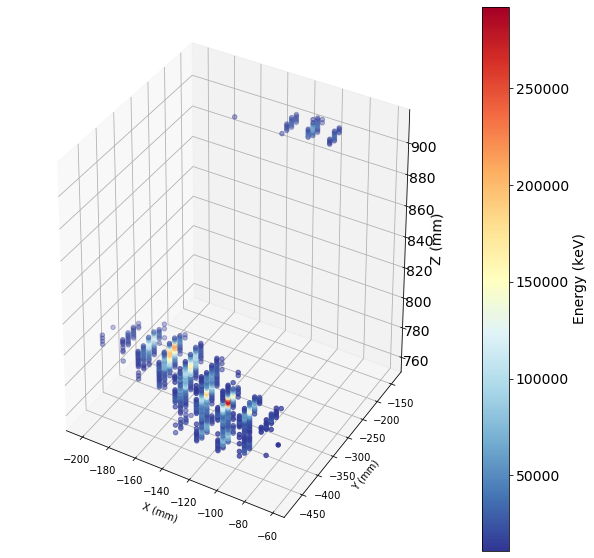

In [237]:
plot_hits3d(sipm_hits,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [238]:
binHits = bin_hits(sipm_hits)

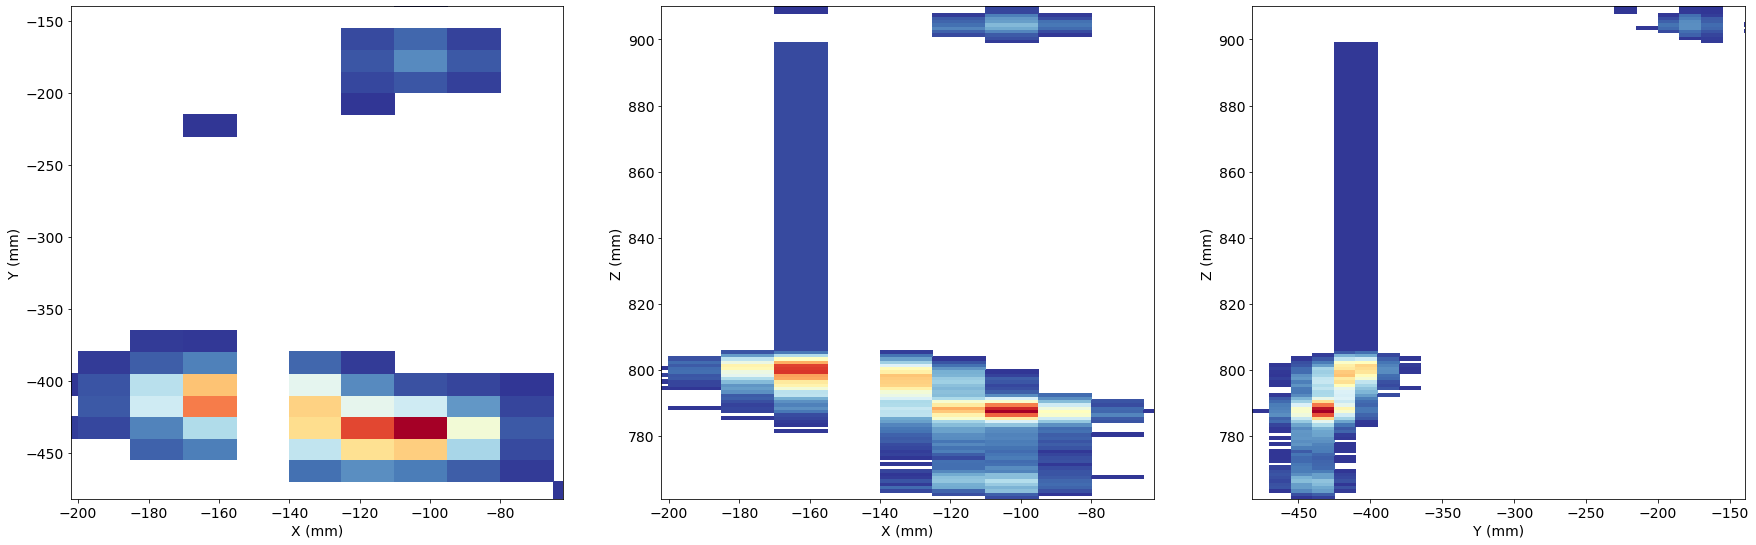

In [239]:
plot_hits_projections(sipm_hits, binHits,  masked=True, figsize=(30, 10))

In [240]:
etot = sipm_hits.df.energy.sum()
emax = sipm_hits.df.energy.max()
print(f" Total energy = {etot}, max energy = {emax}")

 Total energy = 32201, max energy = 292


In [241]:
zsl = np.unique(sipm_hits.df.z.values)
print(f"number of z slices = {len(zsl)}")

number of z slices = 57


In [242]:
len_slices = [len(sipm_hits.df[sipm_hits.df.z == zs]) for zs in zsl]

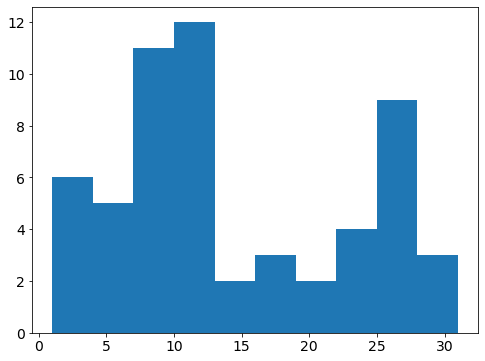

In [243]:
_ = plt.hist(len_slices)

In [244]:
lmax = np.max(len_slices)
ilmax = np.argmax(len_slices)
print(f" length of slice (max) ={lmax}, i = {ilmax}")

 length of slice (max) =31, i = 27


In [245]:
dfzm = sipm_hits.df[sipm_hits.df.z == zsl[ilmax]].reset_index(drop=True)

In [246]:
print(f"""
Larger slice in z at position = {zsl[ilmax]}
numper of hits                = {len(dfzm)}
max energy =                  = {dfzm.energy.max()}
        """)


Larger slice in z at position = 788.0
numper of hits                = 31
max energy =                  = 272
        


In [247]:
dfzn = dfzm.copy()

In [248]:
dfzn['energy'] = dfzn.energy / emax

In [249]:
dfzn.energy.max()

0.9315068493150684

In [250]:
dfzn.head()

,x,y,z,energy
0,-139.949997,-466.5,788.0,0.075342
1,-124.400002,-466.5,788.0,0.065068
2,-108.849998,-466.5,788.0,0.089041
3,-93.300003,-466.5,788.0,0.085616
4,-77.750000,-466.5,788.0,0.047945


In [251]:
binHits = bin_hits_xy(dfzn)

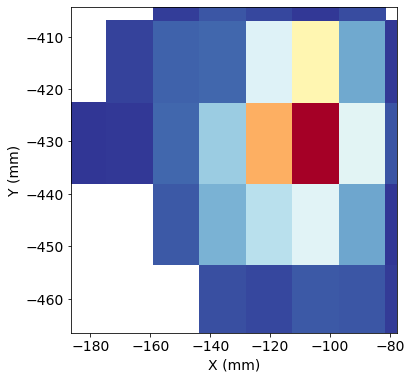

In [252]:
plot_hits_xy(dfzn, binHits,  masked=True, figsize=(6, 6))

##### With a 10 pes cut, the region is compact, no rogue SiPMs

#### Labelling a slice in z and selecting by label

In [253]:
sckl = label_slice(dfzn)

In [254]:
sckl.lbl

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0]])

In [262]:
sckl.xe

array([[0.        , 0.        , 0.03767123, 0.        , 0.        ],
       [0.        , 0.        , 0.04452055, 0.05821918, 0.        ],
       [0.        , 0.0890411 , 0.10958904, 0.10273973, 0.05136986],
       [0.07534247, 0.22945205, 0.28082192, 0.10958904, 0.08561644],
       [0.06506849, 0.32876712, 0.6609589 , 0.39041096, 0.06506849],
       [0.0890411 , 0.40068493, 0.93150685, 0.51027397, 0.04452055],
       [0.08561644, 0.20547945, 0.40410959, 0.20890411, 0.07191781],
       [0.04794521, 0.04109589, 0.08219178, 0.04452055, 0.        ]])

In [265]:
sckl.xl

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.]])

In [256]:
print_properties(sckl.prp)

 region = 0,
        size        = 8
        label       = 1
        diameter    = 6.282549314314218
        euler number= 1
        extent      = 0.775
        filled area = 31
        coordinates = [[0 2]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [7 0]
 [7 1]
 [7 2]
 [7 3]]
        intensity   = [[  0.   0.  11.   0.   0.]
 [  0.   0.  13.  17.   0.]
 [  0.  26.  32.  30.  15.]
 [ 22.  67.  82.  32.  25.]
 [ 19.  96. 193. 114.  19.]
 [ 26. 117. 272. 149.  13.]
 [ 25.  60. 118.  61.  21.]
 [ 14.  12.  24.  13.   0.]]
        


##### In the selection by size we require a size of at least 2 (no isolated SiPMs)

In [268]:
dfzs = select_slice_by_label(dfzn, sckl, min_size=2)

In [269]:
print(f""" 
selection in z:
xmin = {dfzs.x.min()}
xmax = {dfzs.x.max()}
ymin = {dfzs.y.min()}
ymax = {dfzs.y.max()}

""")

 
selection in z:
xmin = -186.60000610351562
xmax = -77.75
ymin = -466.5
ymax = -404.29998779296875




In [270]:
xx = dfzs.x.mean()
yy = dfzs.y.mean()
zz = dfzn.z.values[0]
print(f"xmean = {xx}, ymean={yy} zmean = {zz}")

xmean = -124.90161378922001, ymean=-441.4193548387097 zmean = 788.0


#### Prepare detector grid

In [271]:
det_grid = detector_grid(dfzs, bin_size)

In [272]:
izn = image_from_df(dfzs, det_grid, sample_width)

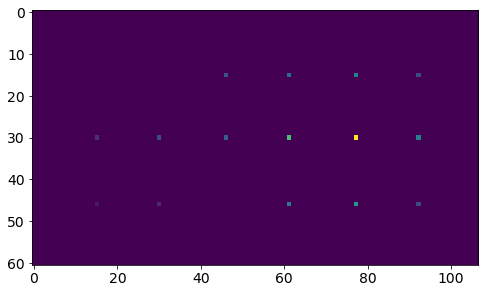

In [273]:
plt.imshow(izn.T)

#### Interpolation 

In [274]:
interpolator = deconvolution_input(sample_width, 
                                   det_grid, 
                                   inter_method)

In [275]:
inter_values, inter_pos = interpolator((dfzs.x.values, dfzs.y.values), dfzs.energy.values)

In [276]:
len(inter_values.flatten())

6696

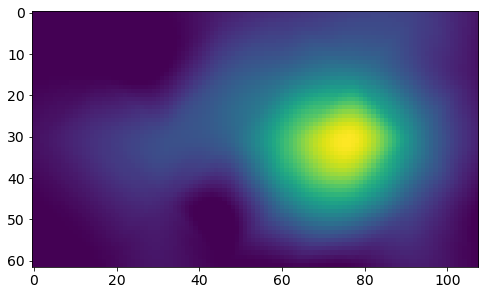

In [277]:
plt.imshow(inter_values.T)

In [278]:
inter_pos[0].shape

(6696,)

In [279]:
dfzi = pd.DataFrame({'x' : inter_pos[0].flatten(), 
                     'y' : inter_pos[1].flatten(), 
                     'energy' : inter_values.flatten() })

In [280]:
binHits = bin_hits_xy(dfzi,
            xr = (dfzi.x.min(), dfzi.x.max()),
            yr = (dfzi.y.min(), dfzi.y.max()),
            pitch = (1, 1))

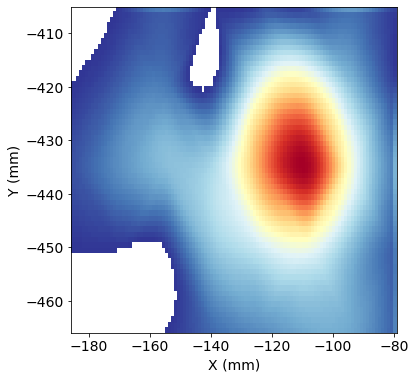

In [281]:
plot_hits_xy(dfzi, binHits,  masked=True, figsize=(6, 6))

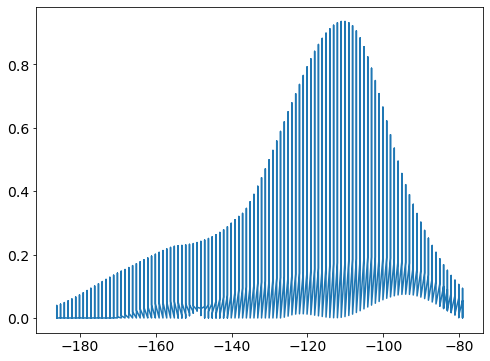

In [282]:
plt.plot(dfzi.x, dfzi.energy)

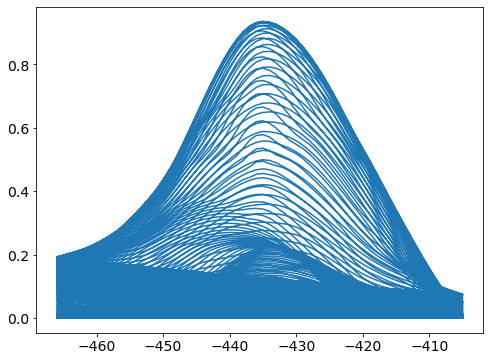

In [283]:
plt.plot(dfzi.y, dfzi.energy)

#### PSF

In [286]:
psf_deco = get_psf(pspath, psfname, dfzs, xyz)

In [287]:
start_time = time.perf_counter() 
deconv_image  = np.nan_to_num(richardson_lucy(inter_values, psf_deco, 70, 1e-10))
                                                     
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'LR from IC run in {run_time} seconds')

LR from IC run in 0.38256817100045737 seconds


In [288]:
deconv_image.T.shape

(62, 108)

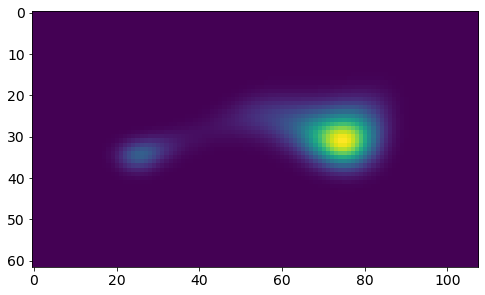

In [289]:
plt.imshow(deconv_image.T)

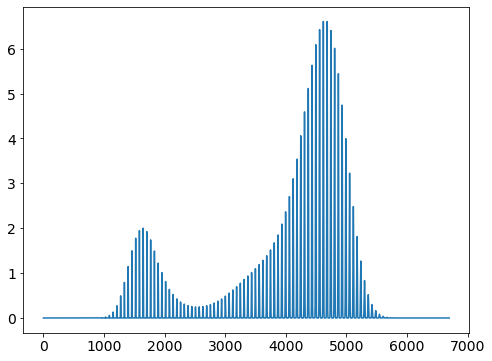

In [290]:
plt.plot(deconv_image.flatten())

In [291]:
dcdf = pd.DataFrame({"x" : inter_pos[0],
                     "y" : inter_pos[1],
                    "energy" : deconv_image.flatten()})

In [292]:
dcdf = dcdf[dcdf.energy>0.01]

In [293]:
binHits = bin_hits_xy(dcdf,
            xr = (dcdf.x.min(), dcdf.x.max()),
            yr = (dcdf.y.min(), dcdf.y.max()),
            pitch = (1, 1))

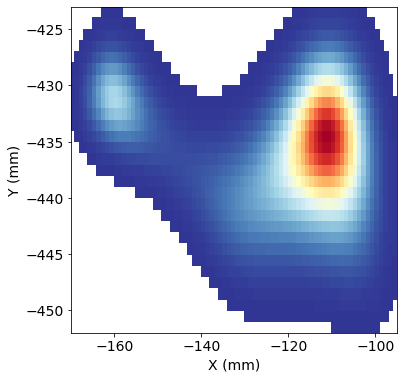

In [294]:
plot_hits_xy(dcdf, binHits,  masked=True, figsize=(6, 6))

### Deconvolution all slices

In [310]:
def deconvolution(sipm_hits, 
                  bin_size     = (1., 1.),
                  sample_width = (15.5, 15.5),
                  inter_method = InterpolationMethod.cubic, 
                  n_iter       = 70,
                  e_min        = 0.01,
                  interactive  = True):
    """
    Deconvolution of the sipm_hits 
    
    """
    etot = sipm_hits.df.energy.sum()
    emax = sipm_hits.df.energy.max()
    print(f" Total energy = {etot}, max energy = {emax}")

    zsl = np.unique(sipm_hits.df.z.values)
    print(f"number of z slices = {len(zsl)}")

    Z = []
    X = []
    Y = []
    E = []

    for iz, z in enumerate(zsl):
        # take z slices and normalise their energy 
        dfzm = sipm_hits.df[sipm_hits.df.z == z].reset_index(drop=True)
        dfzn = dfzm.copy()
        dfzn['energy'] = dfzn.energy / emax
        
        if interactive:

            print(f"""
            Slice number {iz} in z  position = {z}
            number of xy hits for this slice = {len(dfzn)}
            max energy wrt max in event      = {dfzn.energy.max()}
                """)
            
            print(dfzn)

            binHits = bin_hits_xy(dfzn)
            
            print(binHits)
            plot_hits_xy(dfzn, binHits,  masked=True, figsize=(6, 6))
            plt.show()
            x = input('->')

        # define labeled regions
        sckl = label_slice(dfzn)
        
        if interactive:
            print(f"Properties of labeled regions")
            print_properties(sckl.prp)
            x = input('->')

        # select slices by label:
        # Only regions label as signal and larger than 1 SiPM are considered
        
        dfzs = select_slice_by_label(dfzn, sckl, min_size=2)
        
        if dfzs is None:
            print(f"slice is too small, skipping")
            continue
            
        xx = dfzs.x.mean()
        yy = dfzs.y.mean()
        zz = z
        
        # Compute detector grid
        det_grid = detector_grid(dfzs, bin_size)
        
        if interactive:
            print(f" For this slice: xmean = {xx}, ymean={yy} zmean = {zz}")
        
            izn = image_from_df(dfzs, det_grid, sample_width)
            plt.imshow(izn.T)
            plt.show()
            x = input('->')
            
        # interpolation 
        interpolator = deconvolution_input(sample_width, 
                                       det_grid, 
                                       inter_method)
        inter_values, inter_pos = interpolator((dfzs.x.values, dfzs.y.values), 
                                               dfzs.energy.values)
        if interactive:
            plt.imshow(inter_values.T)
            plt.show()
            x = input('->')

        dfzi = pd.DataFrame({'x' : inter_pos[0].flatten(), 
                             'y' : inter_pos[1].flatten(), 
                            'energy' : inter_values.flatten() })
        
        if interactive:
            binHits = bin_hits_xy(dfzi,
                            xr = (dfzi.x.min(), dfzi.x.max()),
                            yr = (dfzi.y.min(), dfzi.y.max()),
                            pitch = bin_size)

            plot_hits_xy(dfzi, binHits,  masked=True, figsize=(6, 6))
            plt.show()
            x = input('->')
            plt.plot(dfzi.x, dfzi.energy)
            plt.show()
            x = input('->')
            plt.plot(dfzi.y, dfzi.energy)
            plt.show()
            x = input('->')
            
        
        #psf
        psf_deco = get_psf(pspath, psfname, dfzs, xyz)
        
        # deconvolve image
        start_time = time.perf_counter() 
        deconv_image  = np.nan_to_num(richardson_lucy(inter_values, psf_deco, n_iter, 1e-10))                                     
        end_time   = time.perf_counter()      # 2
        run_time   = end_time - start_time 
        print(f'LR from IC run in {run_time} seconds')
        
        if interactive:
            plt.imshow(deconv_image.T)
            plt.show()
            x = input('->')
            plt.plot(deconv_image.flatten())
            plt.show()
            x = input('->')

        dcdf = pd.DataFrame({"x" : inter_pos[0],
                             "y" : inter_pos[1],
                             "energy" : deconv_image.flatten()})
        
        dcdf = dcdf[dcdf.energy> e_min]

        if interactive:
            binHits = bin_hits_xy(dcdf,
                    xr = (dcdf.x.min(), dcdf.x.max()),
                    yr = (dcdf.y.min(), dcdf.y.max()),
                    pitch = bin_size)
            
            plot_hits_xy(dcdf, binHits,  masked=True, figsize=(6, 6))
            plt.show()
            x = input('->')
            
        Z.extend(list(z * np.ones(len(dcdf.x.values))))
        X.extend(list(dcdf.x.values))
        Y.extend(list(dcdf.y.values))
        E.extend(list(dcdf.energy.values))

    return pd.DataFrame({"x" : X, "y" : Y, "z" : Z, "energy" : E})


In [311]:
dcdf = deconvolution(sipm_hits, 
   
                     bin_size     = (1., 1.),
                  sample_width = (15.5, 15.5),
                  inter_method = InterpolationMethod.cubic, 
                  n_iter       = 70,
                  e_min        = 0.01,
                  interactive  = False)


 Total energy = 32201, max energy = 292
number of z slices = 57
slice is too small, skipping
LR from IC run in 0.22321301999909338 seconds
LR from IC run in 0.28418919400064624 seconds
LR from IC run in 0.2814928779989714 seconds
LR from IC run in 0.2861571690009441 seconds
LR from IC run in 0.2634435729996767 seconds
LR from IC run in 0.25798604999727104 seconds
LR from IC run in 0.24811721999867586 seconds
LR from IC run in 0.2404142060004233 seconds
LR from IC run in 0.22361436000210233 seconds
LR from IC run in 0.21300239300035173 seconds
LR from IC run in 0.24866552800085628 seconds
LR from IC run in 0.2645617840025807 seconds
LR from IC run in 0.220274718998553 seconds
LR from IC run in 0.23655359699841938 seconds
LR from IC run in 0.23006915100268088 seconds
LR from IC run in 0.25913040399973397 seconds
LR from IC run in 0.2293098509981064 seconds
LR from IC run in 0.2617423740011873 seconds
LR from IC run in 0.24574035899786395 seconds
LR from IC run in 0.27619925399994827 seco

In [312]:
dcdf

,x,y,z,energy
0,-115.900002,-444.450012,762.0,0.020589
1,-115.900002,-443.450012,762.0,0.032784
2,-115.900002,-442.450012,762.0,0.035294
3,-115.900002,-441.450012,762.0,0.025693
4,-115.900002,-440.450012,762.0,0.012649
...,...,...,...,...
32254,-102.900002,-172.100006,907.0,0.022052
32255,-102.900002,-171.100006,907.0,0.030875
32256,-102.900002,-170.100006,907.0,0.032844
32257,-102.900002,-169.100006,907.0,0.026544


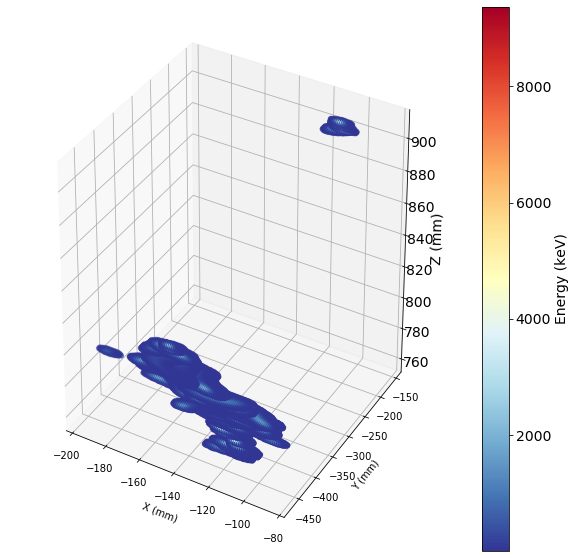

In [314]:
plot_hits3d(dcdf,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [316]:
len(dcdf)

32259

In [317]:
dcdf.head()

,x,y,z,energy
0,-115.900002,-444.450012,762.0,0.020589
1,-115.900002,-443.450012,762.0,0.032784
2,-115.900002,-442.450012,762.0,0.035294
3,-115.900002,-441.450012,762.0,0.025693
4,-115.900002,-440.450012,762.0,0.012649


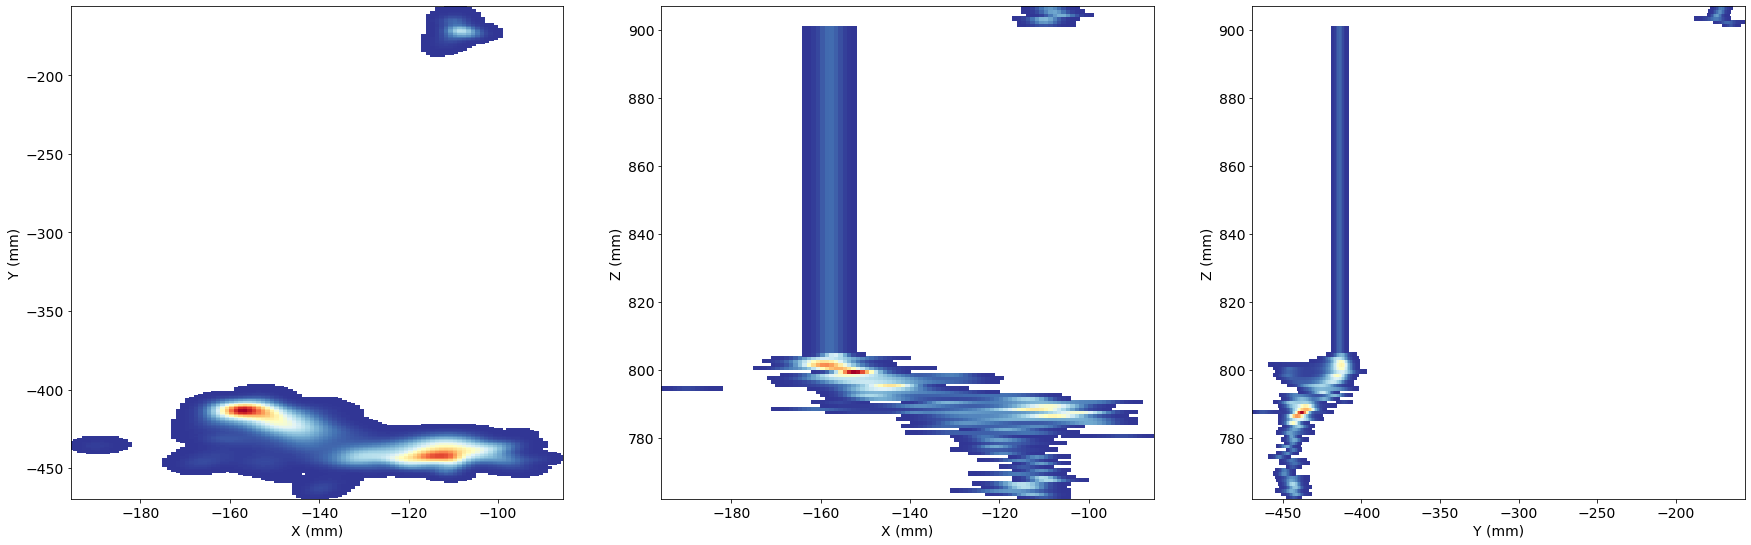

In [318]:
binHits = bin_hits(dcdf, pitch = bin_size)
plot_hits_projections(dcdf, binHits,  masked=True, figsize=(30, 10))